In [119]:
import numpy as np
import scipy.fftpack
import os
import json
import matplotlib.pyplot as pl
from sdirl.experiments import L2Error, OrderError, ProportionError
from sdirl.gridworld.mdp import *
from sdirl.rl.simulator import *
from sdirl.model import *
from matplotlib import rc
%matplotlib inline

In [196]:
class ExperimentLog():
    def __init__(self, file):
        with open(file) as f:
            self.log = json.load(f)
        self.comp_phase = 0
        self.err_phase = 1
        for i, phase in enumerate(self.log["phases"]):
            if phase["name"] == "Compute Bolfi Posterior":
                self.comp_phase = i
            elif phase["name"] == "Compute Bolfi Errors":
                self.err_phase = i
            elif "duration" in phase["results"].keys():
                self.comp_phase = i
            elif "errors" in phase["results"].keys():
                self.err_phase = i
            else:
                raise ValueError("Unknown phase {}".format(phase["name"]))

    @property
    def duration(self):
        return self.log["phases"][self.comp_phase]["results"]["duration"]

    def errors(self, name=None):
        if name is None:
            return self.log["phases"][self.err_phase]["results"]["errors"]
        for ename, evals in self.log["phases"][self.err_phase]["results"]["errors"].items():
            if name in ename:
                return evals
        assert False, (name, self.log["phases"][self.err_phase]["results"]["errors"].keys())
        
    def ML_locs(self):
        return [np.array(p["ML"]) for p in self.log["phases"][self.comp_phase]["results"]["posteriors"]]
        
    def has_converged(self, tail_prop=0.05, L2_tolerance=0.1):
        locs = self.ML_locs()
        tail_len = int(len(locs)*tail_prop)
        end_loc = locs[-1]
        diffs = locs[-tail_len:-1] - end_loc
        std_around_end_loc = np.std(diffs, axis=0)
        return float(np.linalg.norm(std_around_end_loc)) < L2_tolerance
        
    @property
    def steps(self):
        for v in self.log["phases"][self.err_phase]["results"]["errors"].values():
            return len(v)

class TestExperimentLog(ExperimentLog):
    def __init__(self, duration=0, errors=[0], steps=1, locs=[[0,0],]):
        self.dur = duration
        self.errs = errors
        self.stps = steps
        self.locs = locs
    
    @property
    def duration(self):
        return self.dur
    
    def errors(self, name=None):
        return self.errs[name]
    
    def ML_locs(self):
        return [np.array(l) for l in self.locs]
    
    @property
    def steps(self):
        return self.stps
        
class ExperimentGroup():
    def __init__(self, name, experiments):
        self.name = name
        self.exp = experiments
        self.steps = self.exp[0].steps
        for e in self.exp:
            assert e.steps == self.steps, (e.steps, self.steps)
    
    def duration_mean(self):
        return np.mean([e.duration for e in self.exp])
    
    def duration_std(self):
        return np.std([e.duration for e in self.exp])
    
    def print_duration(self):
        print("* Mean duration {:.2f} seconds".format(self.duration_mean()))

    def _get_errors_from_step_matching(self, name, idx, filt=lambda x: True):
        return [e.errors(name)[idx]
                for e in self.exp
                if filt(e.errors(name)) is True]
    
    def error_mean_at_step_matching(self, name, idx, filt=lambda x: True):
        return float(np.mean(self._get_errors_from_step_matching(name, idx, filt)))

    def error_std_at_step_matching(self, name, idx, filt=lambda x: True):
        return float(np.std(self._get_errors_from_step_matching(name, idx, filt)))
        
    def error_mean_matching(self, name, filt=lambda x: True):
        return [self.error_mean_at_step_matching(name, idx, filt)
                for idx in range(self.steps)]
        
    def error_std_matching(self, name,  filt=lambda x: True):
        return [self.error_std_at_step_matching(name, idx, filt)
                for idx in range(self.steps)]
    
    def print_end_error_means(self):
        enames = sorted(self.exp[0].errors().keys())
        for ename in enames:
            end_error_mean = self.error_mean_at_step_matching(ename, -1)
            print("* {} mean {:.2f}".format(ename, end_error_mean))
        
    def print_summary(self):
        print("{} ({} experiments)".format(self.name, len(self.exp)))
        self.print_duration()
        self.print_end_error_means()
        
def plot_barchart(datas, groups=list(), title="", ylabel="", ylim=None, yscale=None, figsize=(5,3), leg_cols=1):
    ind = np.arange(len(groups))
    bar_width = 1.0 / (len(datas)+1)

    fig, ax = pl.subplots(figsize=figsize)
    pl.rc('text', usetex=True)
    pl.rc('font', **{'family':'sans-serif','sans-serif':['Avant Garde']})
    pl.axhline(0, color="k")
    bars = list()
    for i, data in enumerate(datas):
        try:
            vals = [v[-1] for v in data["means"]]
            errs = [v[-1] for v in data["std"]]
        except:
            vals = data["means"]
            errs = data["std"]
        bar = ax.bar(ind + i*bar_width, vals, bar_width, color=data["color"], yerr=errs, ecolor=data["ecolor"])
        bars.append(bar)

    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=12)
    ax.set_xticks(ind + len(datas)*bar_width/2.0)
    ax.set_xticklabels(groups)
    pl.xlim(ind[0]-0.1, ind[-1]+1.1-bar_width)
    if ylim is not None:
        pl.ylim(ylim)
    if yscale is not None:
        pl.yscale(yscale)

    ax.legend([b[0] for b in bars], [d["name"] for d in datas], loc=2, ncol=leg_cols)
    pl.show()
    return fig

def movingaverage(values, window_size=20):
    vals = [values.tolist()[0]] * window_size + values.tolist() + [values.tolist()[-1]] * window_size
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(vals, window, 'same')[window_size:len(values)+window_size]

def _plot_data_to_graph(vals, errs, ax, color, label, smooth, alpha=0.25):
    try:
        x = range(len(vals))
        if smooth is True:
            mav = movingaverage(vals)
            mae = movingaverage(errs)
            ax.plot(x, mav, color, label=label)
            ax.fill_between(x, mav-mae, mav+mae, facecolor=color, alpha=alpha)
        else:
            ax.plot(x, vals, color, label=label)
            ax.fill_between(x, vals+errs, vals-errs, facecolor=color, alpha=alpha)
    except:
        ax.axhline(vals, color=color, label=label)

def plot_graph(datas, groups=list(), title="", ylabel="", ylim=None, yscale=None,
               smooth=False, figsize=(5,5)):
    ind = np.arange(len(groups))
    bar_width = 1.0 / (len(datas)+1)

    fig, axarr = pl.subplots(len(groups), sharex=True, figsize=figsize)
    for i in range(len(groups)):
        if len(groups) > 1:
            ax = axarr[i]
            ax.set_title(groups[i])
        else:
            ax = axarr
        for data in datas:
            vals = np.array(data["means"][i])
            errs = np.array(data["std"][i])
            _plot_data_to_graph(vals, errs, ax, data["color"], data["name"], smooth)
        ax.set_ylabel(ylabel)
        if i+1 == len(groups):
            ax.legend(bbox_to_anchor=(0., -0.3, 1., -1.1), loc=3,
                       ncol=min(2,len(datas)), mode="expand", borderaxespad=0.)
    if smooth is True:
        pl.suptitle(title + " (smoothed)")
    else:
        pl.suptitle(title)
    if ylim is not None:
        pl.ylim(ylim)
    if yscale is not None:
        pl.yscale(yscale)

    pl.show()
    return fig

def extract(objlist, methodname, *args, **kwargs):
    return [getattr(obj, methodname)(*args, **kwargs) for obj in objlist]

def ret_object(typ, *items):
    ret = list()
    for it in items:
        if len(it) == 4:
            name, color, ecolor, data = it
            filt = lambda x: True
        elif len(it) == 5:
            name, color, ecolor, data, filt = it
        else:
            raise ValueError("Wrong item format: {}".format(it))
        d = {"name": name,
             "color": color,
             "ecolor": ecolor,
             "means": None,
             "std": None}
        if typ == "duration":
            d["means"] = extract(data, "duration_mean")
            d["std"] = extract(data, "duration_std")
        else:
            d["means"] = extract(data, "error_mean_matching", typ, filt=filt)
            d["std"] = extract(data, "error_std_matching", typ, filt=filt)
        ret.append(d)
    return ret

def reconstruct_rl(e):
    # hackity hack
    env = e.log["model"]["env"]
    rl = e.log["model"]["rl"]
    grid_size = env["grid_size"]
    prob_rnd_move = 0.05
    n_features = env["n_features"]
    goal_state = State(*eval(env["goal_state"]))
    initial_state_generator = InitialStateUniformlyAtEdge(grid_size)
    grid_generator = WallsGrid(env["grid_generator"]["world_seed"], grid_size)
    gwe = GridWorldEnvironment(grid_size, prob_rnd_move, n_features, goal_state,
                               initial_state_generator, grid_generator)
    gwt = GridWorldTask(gwe, grid_size*3, 0.05)
    params = list()
    for p in rl["parameters"]:
        params.append(ModelParameter(p["name"], p["bounds"],
                                     ParameterPrior(p["prior"]["distribution_name"], p["prior"]["params"])))
    rlp = RLParams(rl["rl_params"]["n_training_episodes"],
                   rl["rl_params"]["n_episodes_per_epoch"],
                   rl["rl_params"]["n_simulation_episodes"],
                   rl["rl_params"]["q_alpha"],
                   rl["rl_params"]["q_gamma"],
                   rl["rl_params"]["exp_epsilon"],
                   rl["rl_params"]["exp_decay"])
    return RLSimulator(rlp, params, gwe, gwt)

def test_experiments():
    ex1 = TestExperimentLog(1, {"A": [1,1,1,2,2,2], "B": [2,2,2,4,4,4]}, 6)
    ex2 = TestExperimentLog(2, {"A": [1,1,1,2,2,2], "B": [3,3,3,3,3,3]}, 6)
    eg1 = ExperimentGroup("test1", [ex1, ex2])
    assert eg1.duration_mean() == 1.5
    assert eg1.duration_std() == 0.5
    assert eg1._get_errors_from_step_matching("A", 0) == [1,1]
    assert eg1._get_errors_from_step_matching("B", 3) == [4,3]
    assert eg1.error_mean_at_step_matching("A", 0) == 1
    assert eg1.error_mean_at_step_matching("B", 3) == 3.5
    assert eg1.error_std_at_step_matching("A", 0) == 0
    assert eg1.error_std_at_step_matching("B", 3) == 0.5
    assert eg1.error_mean_matching("A") == [1,1,1,2,2,2]
    assert eg1.error_mean_matching("B") == [2.5, 2.5, 2.5, 3.5, 3.5, 3.5]
    assert eg1.error_std_matching("A") == [0,0,0,0,0,0]
    assert eg1.error_std_matching("B") == [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
    filt = lambda x: x[-1] == 3
    assert eg1.error_mean_matching("B", filt) == [3,3,3,3,3,3]
    assert eg1.error_std_matching("B", filt) == [0,0,0,0,0,0]
    
    ex3 = TestExperimentLog(2, {"A": [2,2,2,2,2,2], "B": [0,0,0,0,0,0]}, 6)
    ex4 = TestExperimentLog(4, {"A": [1,1,1,1,1,1], "B": [0,0,0,1,1,1]}, 6)
    eg2 = ExperimentGroup("test2", [ex3, ex4])
    objs = [eg1, eg2]
    ret = ret_object("duration", ("Test", "g", "r", objs))
    assert len(ret) == 1
    assert ret[0]["name"] == "Test"
    assert ret[0]["color"] == "g"
    assert ret[0]["ecolor"] == "r"
    assert ret[0]["means"] == [1.5, 3]
    assert ret[0]["std"] == [0.5, 1]
    ret = ret_object("A", ("Test", "g", "r", objs))
    assert len(ret) == 1
    assert ret[0]["name"] == "Test"
    assert ret[0]["color"] == "g"
    assert ret[0]["ecolor"] == "r"
    assert ret[0]["means"] == [[1,1,1,2,2,2], [1.5, 1.5, 1.5, 1.5, 1.5, 1.5]]
    assert ret[0]["std"] == [[0,0,0,0,0,0], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]
    filt = lambda x: x[-1] in [0, 3]
    ret = ret_object("B", ("Test", "g", "r", objs, filt))
    assert len(ret) == 1
    assert ret[0]["name"] == "Test"
    assert ret[0]["color"] == "g"
    assert ret[0]["ecolor"] == "r"
    assert ret[0]["means"] == [[3,3,3,3,3,3], [0,0,0,0,0,0]]
    assert ret[0]["std"] == [[0,0,0,0,0,0], [0,0,0,0,0,0]]
    
    ex5 = TestExperimentLog(locs=[[-0.1, -0.1], [0.1, 0.1], [0.0, 0.0]])
    ex6 = TestExperimentLog(locs=[[0.0, 0.0], [0.1, 0.1], [0.0, 0.0]])
    assert ex5.has_converged(1.0) is False
    assert ex6.has_converged(1.0) is True
    print("All ok")
    
test_experiments()

All ok


<h1>Duration comparison experiment</h1>

In [213]:
gt_3x3_exact = ExperimentGroup("3x3 grid exact inference", [
    ExperimentLog("../results/time/gt8_{}/experiment_grid_3_approx_False.json".format(i))
        for i in [1,2,3,4,5,6,7,8,9,10]])
gt_3x3_approx = ExperimentGroup("3x3 grid approx inference", [
    ExperimentLog("../results/time/gt8_{}/experiment_grid_3_approx_True.json".format(i))
        for i in [1,2,3,4,5,6,7,8,9,10]])
gt_5x5_exact = ExperimentGroup("5x5 grid exact inference", [
    ExperimentLog("../results/time/gt8_{}/experiment_grid_5_approx_False.json".format(i))
        for i in [1,2,3,4,5,6,7,8,9,10]])
gt_5x5_approx = ExperimentGroup("5x5 grid approx inference", [
    ExperimentLog("../results/time/gt8_{}/experiment_grid_5_approx_True.json".format(i))
        for i in [1,2,3,4,5,6,7,8,9,10]])
#gt_7x7_exact = ExperimentGroup("7x7 grid exact inference", [
#    ExperimentLog("../results/time/gt8_{}/experiment_grid_7_approx_False.json".format(i))
#        for i in [1,2,3,4,5,6,7,8,9,10]])
#gt_7x7_approx = ExperimentGroup("7x7 grid approx inference", [
#    ExperimentLog("../results/time/gt8_{}/experiment_grid_7_approx_True.json".format(i))
#        for i in [1,2,3,4,5,6,7,8,9,10]])

gt_3x3_exact.print_summary()
gt_3x3_approx.print_summary()
gt_5x5_exact.print_summary()
gt_5x5_approx.print_summary()
#gt_7x7_exact.print_summary()
#gt_7x7_approx.print_summary()

def get_duration_datas():
    exact = [gt_3x3_exact,
             gt_5x5_exact,
             #gt_7x7_exact
            ]
    approx = [gt_3x3_approx,
              gt_5x5_approx,
              #gt_7x7_approx
             ]
    datas = ret_object("duration", ("EXACT", "orange", "k", exact), ("APPROX", "dodgerblue", "k", approx))
    datas[0]["std"] = None
    datas[1]["std"] = None
    return datas

3x3 grid exact inference (10 experiments)
* Mean duration 6.68 seconds
* L2 error to [ 0.] mean 0.00
* Order error to [ 0.] mean 0.00
* Proportion error to [ 0.] mean -inf
3x3 grid approx inference (10 experiments)
* Mean duration 6.86 seconds
* L2 error to [ 0.] mean 0.00
* Order error to [ 0.] mean 0.00
* Proportion error to [ 0.] mean -inf
5x5 grid exact inference (10 experiments)
* Mean duration 1168.50 seconds
* L2 error to [ 0.] mean 0.00
* Order error to [ 0.] mean 0.00
* Proportion error to [ 0.] mean -inf
5x5 grid approx inference (10 experiments)
* Mean duration 8.86 seconds
* L2 error to [ 0.] mean 0.00
* Order error to [ 0.] mean 0.00
* Proportion error to [ 0.] mean -inf


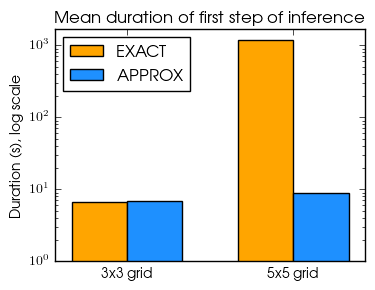

In [214]:
datas = get_duration_datas()
groups = ["3x3 grid",
          "5x5 grid",
          #"7x7 grid"
         ]
title = "Mean duration of first step of inference "
ylabel = "Duration (s), log scale"
ylim = (1e0, 1.7e3)
fig = plot_barchart(datas, groups, title, ylabel, ylim, yscale="log", figsize=(4,3))
fig.savefig('../results/one_step_duration.png', bbox_inches='tight')

<h1>Exact vs. approximate inference quality experiment</h1>

In [207]:
gt_5x5_2f_exact = ExperimentGroup("7x7 grid 2 features exact inference", [
    ExperimentLog("../results/both5/gb5_7x7_2f_{}/experiment_approx_False.json".format(i))
        for i in [1,12,13,14,15]])
gt_5x5_2f_approx = ExperimentGroup("7x7 grid 2 features approx inference", [
    ExperimentLog("../results/both5/gb5_7x7_2f_{}/experiment_approx_True.json".format(i))
        for i in [1,12,13,14,15]])
#gt_5x5_3f_exact = ExperimentGroup("5x5 grid 3 features exact inference", [
#    ExperimentLog("../results/both/gb4_5x5_3f_{}/experiment_approx_False.json".format(i))
#        for i in [1,2,3,4,5,6,7]])
#gt_5x5_3f_approx = ExperimentGroup("5x5 grid 3 features approx inference", [
#    ExperimentLog("../results/both/gb4_5x5_3f_{}/experiment_approx_True.json".format(i))
#        for i in [1,2,3,4,5,6,7]])

gt_5x5_2f_exact.print_summary()
gt_5x5_2f_approx.print_summary()
#gt_5x5_3f_exact.print_summary()
#gt_5x5_3f_approx.print_summary()

def get_eva_exp_datas(typ=""):
    exact = [gt_5x5_2f_exact,
             #gt_5x5_3f_exact
            ]
    approx = [gt_5x5_2f_approx,
              #gt_5x5_3f_approx
             ]
    ret = ret_object(typ, ("EXACT", "orange", "black", exact), ("APPROX", "dodgerblue", "black", approx))
    return ret

7x7 grid 2 features exact inference (5 experiments)
* Mean duration 186090.17 seconds
* L2 error to [-0.33 -0.67] mean 0.32
* Order error to [-0.33 -0.67] mean 0.40
* Proportion error to [-0.33 -0.67] mean -0.99
7x7 grid 2 features approx inference (5 experiments)
* Mean duration 2714.08 seconds
* L2 error to [-0.33 -0.67] mean 0.27
* Order error to [-0.33 -0.67] mean 0.00
* Proportion error to [-0.33 -0.67] mean -0.64


In [6]:
n_samples = 1000000

gt2 = [-0.33, -0.67]
l2e = L2Error(ground_truth=gt2)
oe = OrderError(ground_truth=gt2)
pe = ProportionError(ground_truth=gt2)
rnd_l2e_2f = [l2e._error([np.random.uniform(-1, 0) for i in range(2)]) for j in range(n_samples)]
rnd_oe_2f = [oe._error([np.random.uniform(-1, 0) for i in range(2)]) for j in range(n_samples)]
rnd_pe_2f = [pe._error([np.random.uniform(-1, 0) for i in range(2)]) for j in range(n_samples)]

gt3 = [-0.25, -0.5, -0.75]
l2e = L2Error(ground_truth=gt3)
oe = OrderError(ground_truth=gt3)
pe = ProportionError(ground_truth=gt3)
rnd_l2e_3f = [l2e._error([np.random.uniform(-1, 0) for i in range(3)]) for j in range(n_samples)]
rnd_oe_3f = [oe._error([np.random.uniform(-1, 0) for i in range(3)]) for j in range(n_samples)]
rnd_pe_3f = [pe._error([np.random.uniform(-1, 0) for i in range(3)]) for j in range(n_samples)]

random_L2_means = [np.mean(rnd_l2e_2f),
                   np.mean(rnd_l2e_3f),
                  ]
random_L2_stds = [np.std(rnd_l2e_2f),
                  np.std(rnd_l2e_3f),
                 ]
random_lp_means = [np.mean(rnd_pe_2f),
                   np.mean(rnd_pe_3f),
                  ]
random_lp_stds = [np.std(rnd_pe_2f),
                   np.std(rnd_pe_3f),
                 ]
random_ord_means = [np.mean(rnd_oe_2f),
                   np.mean(rnd_oe_3f),
                   ]
random_ord_stds = [np.std(rnd_oe_2f),
                   np.std(rnd_oe_3f),
                  ]

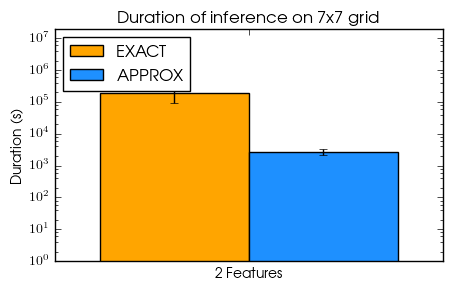

In [208]:
datas = get_eva_exp_datas("duration")
groups = ["2 Features",
          #"3 Features"
         ]
title = "Duration of inference on 7x7 grid"
ylabel = "Duration (s)"
ylim = (1, 2e7)
fig = plot_barchart(datas, groups, title, ylabel, ylim, yscale="log")
fig.savefig('../results/full_duration.png', bbox_inches='tight')

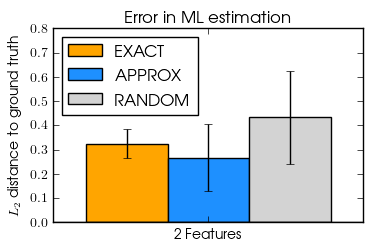

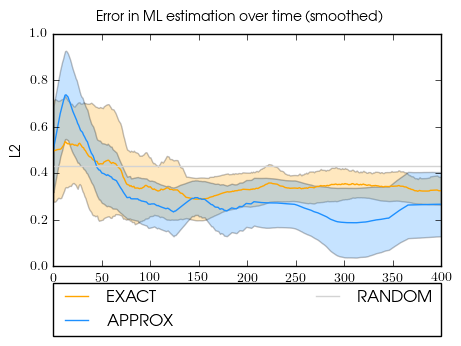

In [210]:
datas = get_eva_exp_datas("L2")
datas.append(
    {"name": "RANDOM",
     "color": "lightgrey",
     "ecolor": "k",
     "means": [random_L2_means[0]],
     "std": [random_L2_stds[0]]})
     #"means": random_L2_means,
     #"std": random_L2_stds})
groups = ["2 Features",
          #"3 Features"
         ]
title = "Error in ML estimation"
ylabel = "$L_2$ distance to ground truth"
ylim = (0, 0.8)
fig = plot_barchart(datas, groups, title, ylabel, ylim, figsize=(4,2.5))
fig.savefig('../results/l2_errors_comp.png', bbox_inches='tight')

fig = plot_graph(datas, groups, title+" over time", ylabel="L2", smooth=True, figsize=(5,3))
fig.savefig('../results/l2_errors_comp_temp.png', bbox_inches='tight')

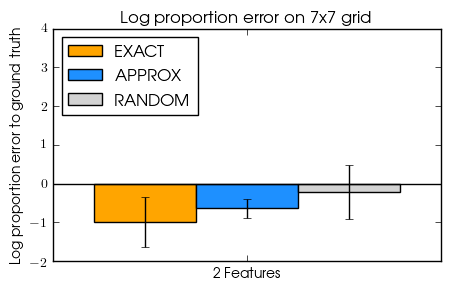

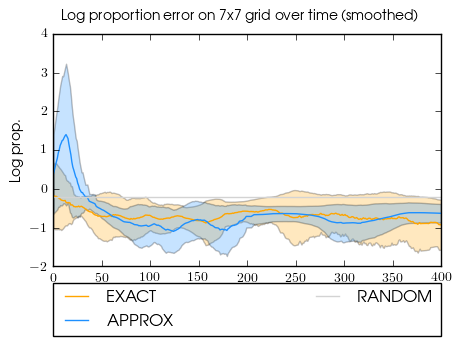

In [211]:
datas = get_eva_exp_datas("Proportion")
datas.append(
    {"name": "RANDOM",
     "color": "lightgrey",
     "ecolor": "k",
     "means": [random_lp_means[0]],
     "std": [random_lp_stds[0]]})
     #"means": random_lp_means,
     #"std": random_lp_stds})
groups = ["2 Features",
          #"3 Features"
         ]
title = "Log proportion error on 7x7 grid"
ylabel = "Log proportion error to ground truth"
ylim = (-2, 4)
fig = plot_barchart(datas, groups, title, ylabel, ylim)
fig.savefig('../results/lp_errors_comp.png', bbox_inches='tight')

fig = plot_graph(datas, groups, title+" over time", ylabel="Log prop.", smooth=True, figsize=(5,3))
fig.savefig('../results/lp_errors_comp_temp.png', bbox_inches='tight')

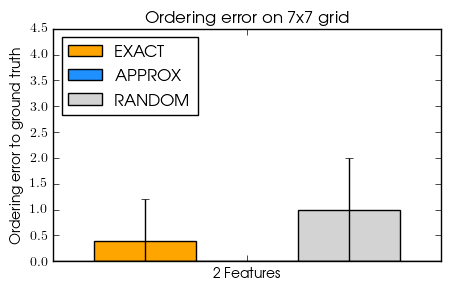

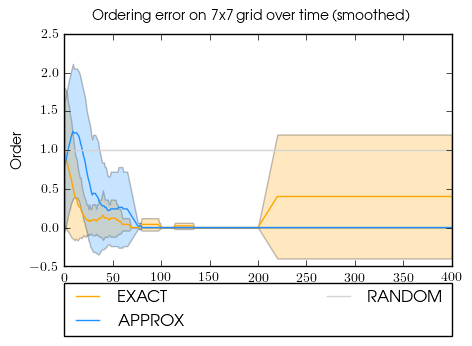

In [212]:
datas = get_eva_exp_datas("Order")
datas.append(
    {"name": "RANDOM",
     "color": "lightgrey",
     "ecolor": "k",
     "means": [random_ord_means[0]],
     "std": [random_ord_stds[0]]})
     #"means": random_ord_means,
     #"std": random_ord_stds})
groups = ["2 Features",
          #"3 Features"
         ]
title = "Ordering error on 7x7 grid"
ylabel = "Ordering error to ground truth"
ylim = (0, 4.5)
fig = plot_barchart(datas, groups, title, ylabel, ylim)
fig.savefig('../results/ord_errors_comp.png', bbox_inches='tight')

fig = plot_graph(datas, groups, title+" over time", ylabel="Order", smooth=True, figsize=(5,3))
fig.savefig('../results/ord_errors_comp_temp.png', bbox_inches='tight')

<h1>Discrepancy based inference scaling up experiment</h1>

In [216]:
gd_9x9_2f = ExperimentGroup("9x9 grid 2 features", [
    ExperimentLog("../results/disc5/gd5_9x9_2f_{}/experiment.json".format(i))
        for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]])
gd_9x9_3f = ExperimentGroup("9x9 grid 3 features", [
    ExperimentLog("../results/disc5/gd5_9x9_3f_{}/experiment.json".format(i))
        for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]])
gd_13x13_2f = ExperimentGroup("13x13 grid 2 features", [
    ExperimentLog("../results/disc5/gd5_13x13_2f_{}/experiment.json".format(i))
        for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]])
gd_13x13_3f = ExperimentGroup("13x13 grid 3 features", [
    ExperimentLog("../results/disc5/gd5_13x13_3f_{}/experiment.json".format(i))
        for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]])
gd_19x19_2f = ExperimentGroup("19x19 grid 2 features", [
    ExperimentLog("../results/disc5/gd5_19x19_2f_{}/experiment.json".format(i))
        for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]])
gd_19x19_3f = ExperimentGroup("19x19 grid 3 features", [
    ExperimentLog("../results/disc5/gd5_19x19_3f_{}/experiment.json".format(i))
        for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]])

gd_9x9_2f.print_summary()
gd_9x9_3f.print_summary()
gd_13x13_2f.print_summary()
gd_13x13_3f.print_summary()
gd_19x19_2f.print_summary()
gd_19x19_3f.print_summary()

9x9 grid 2 features (25 experiments)
* Mean duration 8292.92 seconds
* L2 error to [-0.33 -0.67] mean 0.23
* Order error to [-0.33 -0.67] mean 0.40
* Proportion error to [-0.33 -0.67] mean -0.76
9x9 grid 3 features (25 experiments)
* Mean duration 11350.93 seconds
* L2 error to [-0.25 -0.5  -0.75] mean 0.33
* Order error to [-0.25 -0.5  -0.75] mean 1.04
* Proportion error to [-0.25 -0.5  -0.75] mean -0.25
13x13 grid 2 features (25 experiments)
* Mean duration 13715.81 seconds
* L2 error to [-0.33 -0.67] mean 0.20
* Order error to [-0.33 -0.67] mean 0.16
* Proportion error to [-0.33 -0.67] mean -0.79
13x13 grid 3 features (25 experiments)
* Mean duration 19245.32 seconds
* L2 error to [-0.25 -0.5  -0.75] mean 0.35
* Order error to [-0.25 -0.5  -0.75] mean 1.24
* Proportion error to [-0.25 -0.5  -0.75] mean -0.06
19x19 grid 2 features (25 experiments)
* Mean duration 25487.73 seconds
* L2 error to [-0.33 -0.67] mean 0.16
* Order error to [-0.33 -0.67] mean 0.16
* Proportion error to [-0.

In [217]:
def get_app_exp_datas(typ=""):
    g9 = [gd_9x9_2f, gd_9x9_3f]
    g13 = [gd_13x13_2f, gd_13x13_3f]
    g19 = [gd_19x19_2f, gd_19x19_3f]
    return ret_object(typ,
                     ("9x9", "lightgreen", "k", g9),
                     ("13x13", "mediumseagreen", "k", g13),
                     ("19x19", "green", "k", g19))

In [174]:
if False:
    tail_prop = 0.05
    L2_tolerance = 0.01
    gd_9x9_2f_c = ExperimentGroup("9x9 grid 2 features (conv)",
                    [e for e in gd_9x9_2f.exp if e.has_converged(tail_prop=0.1, L2_tolerance=0.02)])
    gd_9x9_3f_c = ExperimentGroup("9x9 grid 3 features (conv)",
                    [e for e in gd_9x9_3f.exp if e.has_converged(tail_prop=0.1, L2_tolerance=0.02)])
    gd_13x13_2f_c = ExperimentGroup("13x13 grid 2 features (conv)",
                    [e for e in gd_13x13_2f.exp if e.has_converged(tail_prop=0.1, L2_tolerance=0.02)])
    gd_13x13_3f_c = ExperimentGroup("13x13 grid 3 features (conv)",
                    [e for e in gd_13x13_3f.exp if e.has_converged(tail_prop=0.1, L2_tolerance=0.02)])
    gd_19x19_2f_c = ExperimentGroup("19x19 grid 2 features (conv)",
                    [e for e in gd_19x19_2f.exp if e.has_converged(tail_prop=0.1, L2_tolerance=0.02)])
    gd_19x19_3f_c = ExperimentGroup("19x19 grid 3 features (conv)",
                    [e for e in gd_19x19_3f.exp if e.has_converged(tail_prop=0.1, L2_tolerance=0.02)])

    gd_9x9_2f_c.print_summary()
    gd_9x9_3f_c.print_summary()
    gd_13x13_2f_c.print_summary()
    gd_13x13_3f_c.print_summary()
    gd_19x19_2f_c.print_summary()
    gd_19x19_3f_c.print_summary()

    def get_app_exp_datas_conv(typ=""):
        g9 = [gd_9x9_2f_c, gd_9x9_3f_c]
        g13 = [gd_13x13_2f_c, gd_13x13_3f_c]
        g19 = [gd_19x19_2f_c, gd_19x19_3f_c]
        return ret_object(typ,
                         ("9x9 c", "g", g9),
                         ("13x13 c", "r", g13),
                         ("19x19 c", "b", g19))

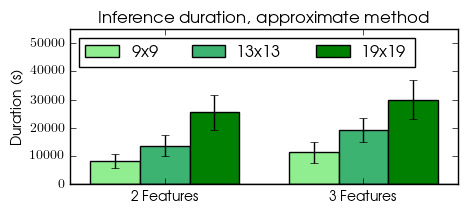

In [218]:
datas = get_app_exp_datas("duration")
groups = ["2 Features", "3 Features"]
title = "Inference duration, approximate method"
ylabel = "Duration (s)"
ylim = (0, 55000)
fig = plot_barchart(datas, groups, title, ylabel, ylim, figsize=(5,2), leg_cols=3)
fig.savefig('../results/disc_duration.png', bbox_inches='tight')

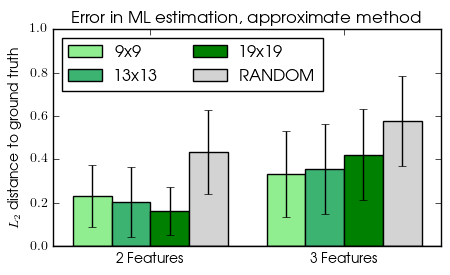

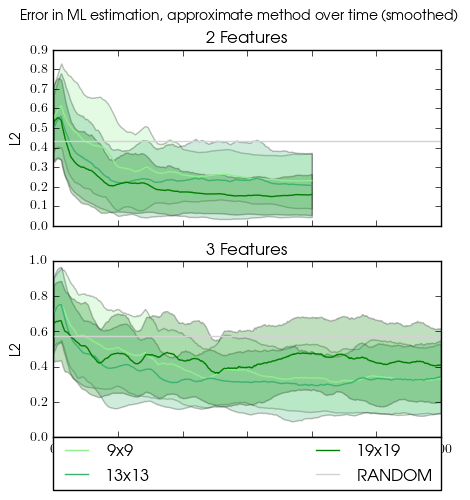

In [223]:
datas = get_app_exp_datas("L2")
datas.append(
    {"name": "RANDOM",
     "color": "lightgrey",
     "ecolor": "k",
     "means": random_L2_means,
     "std": random_L2_stds})
groups = ["2 Features", "3 Features"]
title = "Error in ML estimation, approximate method"
ylabel = "$L_2$ distance to ground truth"
ylim = (0, 1.0)
fig = plot_barchart(datas, groups, title, ylabel, ylim, figsize=(5,2.8), leg_cols=2)
fig.savefig('../results/disc_l2_errors_comp.png', bbox_inches='tight')

fig = plot_graph(datas, groups, title+" over time", ylabel="L2", smooth=True)
fig.savefig('../results/disc_l2_errors_comp_temp.png', bbox_inches='tight')

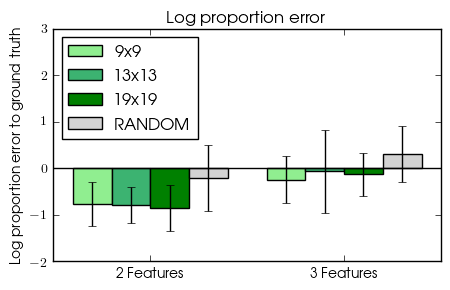

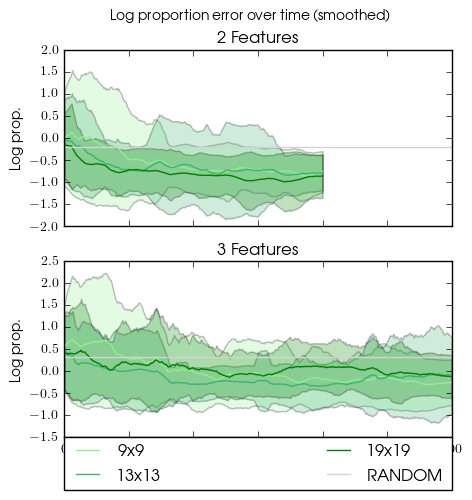

In [220]:
datas = get_app_exp_datas("Proportion")
datas.append(
    {"name": "RANDOM",
     "color": "lightgrey",
     "ecolor": "k",
     "means": random_lp_means,
     "std": random_lp_stds})
groups = ["2 Features", "3 Features"]
title = "Log proportion error"
ylabel = "Log proportion error to ground truth"
ylim = (-2, 3)
fig = plot_barchart(datas, groups, title, ylabel, ylim)
fig.savefig('../results/disc_lp_errors_comp.png', bbox_inches='tight')

fig = plot_graph(datas, groups, title+" over time", ylabel="Log prop.", smooth=True)
fig.savefig('../results/disc_lp_errors_comp_temp.png', bbox_inches='tight')

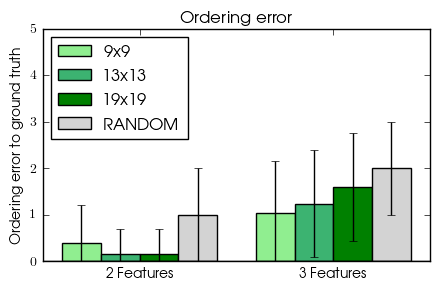

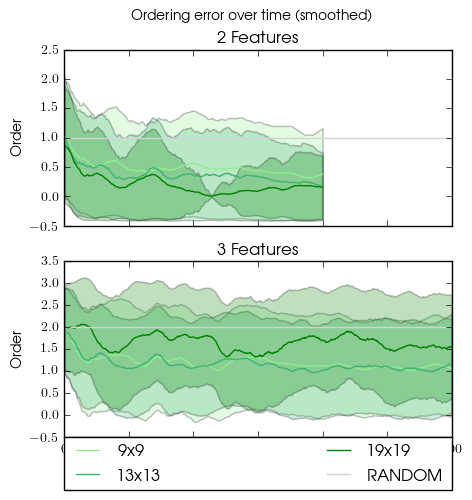

In [221]:
datas = get_app_exp_datas("Order")
datas.append(
    {"name": "RANDOM",
     "color": "lightgrey",
     "ecolor": "k",
     "means": random_ord_means,
     "std": random_ord_stds})
groups = ["2 Features", "3 Features"]
title = "Ordering error"
ylabel = "Ordering error to ground truth"
ylim = (0, 5)
fig = plot_barchart(datas, groups, title, ylabel, ylim)
fig.savefig('../results/disc_ord_errors_comp.png', bbox_inches='tight')

fig = plot_graph(datas, groups, title+" over time", ylabel="Order", smooth=True)
fig.savefig('../results/disc_ord_errors_comp_temp.png', bbox_inches='tight')

In [222]:
e = ExperimentLog("../results/disc5/gd5_9x9_2f_1/experiment.json")

In [74]:
rl = reconstruct_rl(e)

In [75]:
rl.train_model([-0.3, -0.6], np.random.RandomState(0))

 /home/akangasr/elfi/.venv/lib/python3.4/site-packages/pybrain/rl/agents/logging.py:55: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.
 /home/akangasr/elfi/.venv/lib/python3.4/site-packages/pybrain/datasets/sequential.py:49: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future
 /home/akangasr/elfi/.venv/lib/python3.4/site-packages/pybrain/datasets/sequential.py:45: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future


In [76]:
sim = rl.simulate(np.random.RandomState(0))

 /home/akangasr/elfi/.venv/lib/python3.4/site-packages/pybrain/rl/agents/logging.py:55: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.
